1. Считать в `pandas.DataFrame` любой источник данных: CSV, JSON, Excel-файл, HTML-таблицу и т.п.


In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, learning_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay


df = pd.read_csv('drugs.csv')

print(df.head())
print(df.info())

   Age Sex      BP Cholesterol  Na_to_K   Drug
0   23   F    HIGH        HIGH   25.355  DrugY
1   47   M     LOW        HIGH   13.093  drugC
2   47   M     LOW        HIGH   10.114  drugC
3   28   F  NORMAL        HIGH    7.798  drugX
4   61   F     LOW        HIGH   18.043  DrugY
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          200 non-null    int64  
 1   Sex          200 non-null    object 
 2   BP           200 non-null    object 
 3   Cholesterol  200 non-null    object 
 4   Na_to_K      200 non-null    float64
 5   Drug         200 non-null    object 
dtypes: float64(1), int64(1), object(4)
memory usage: 9.5+ KB
None


2) Описание датасета

Датасет содержит следующие признаки:
- Age – возраст пациента
- Sex – пол пациента (M/F)
- BP – уровень кровяного давления (HIGH, LOW, NORMAL)
- Cholesterol – уровень холестерина (HIGH, NORMAL)
- Na_to_K – соотношение натрия к калию
- Drug – принимаемый препарат (целевая переменная)

Цель:
- Бинарная классификация: например, определить, принимает ли пациент 'DrugY' или нет.
- Многоклассовая: определить конкретный препарат.


 3. Предобработка данных

In [ ]:
le = LabelEncoder()

df['Drug_binary'] = df['Drug'].apply(lambda x: 1 if x == 'DrugY' else 0)

for col in ['Sex', 'BP', 'Cholesterol']:
    df[col] = le.fit_transform(df[col])

df.dropna(inplace=True)

print(df.head())

   Age  Sex  BP  Cholesterol  Na_to_K   Drug  Drug_binary
0   23    0   0            0   25.355  DrugY            1
1   47    1   1            0   13.093  drugC            0
2   47    1   1            0   10.114  drugC            0
3   28    0   2            0    7.798  drugX            0
4   61    0   1            0   18.043  DrugY            1


4. Разбиение на train/test (одинаковое для всех задач)

In [ ]:
X_binary = df.drop(['Drug', 'Drug_binary'], axis=1)
y_binary = df['Drug_binary']

X_multi = df.drop('Drug', axis=1)
y_multi = df['Drug']

X_train_bin, X_test_bin, y_train_bin, y_test_bin = train_test_split(
    X_binary, y_binary, test_size=0.3, random_state=42
)

X_train_multi, X_test_multi, y_train_multi, y_test_multi = train_test_split(
    X_multi, y_multi, test_size=0.3, random_state=42
)

5. Нормализация данных

In [ ]:
scaler = StandardScaler()

X_train_bin_scaled = scaler.fit_transform(X_train_bin)
X_test_bin_scaled = scaler.transform(X_test_bin)

X_train_multi_scaled = scaler.fit_transform(X_multi)
X_test_multi_scaled = scaler.transform(X_test_multi)

6. Correlation Heatmap и отбор признаков

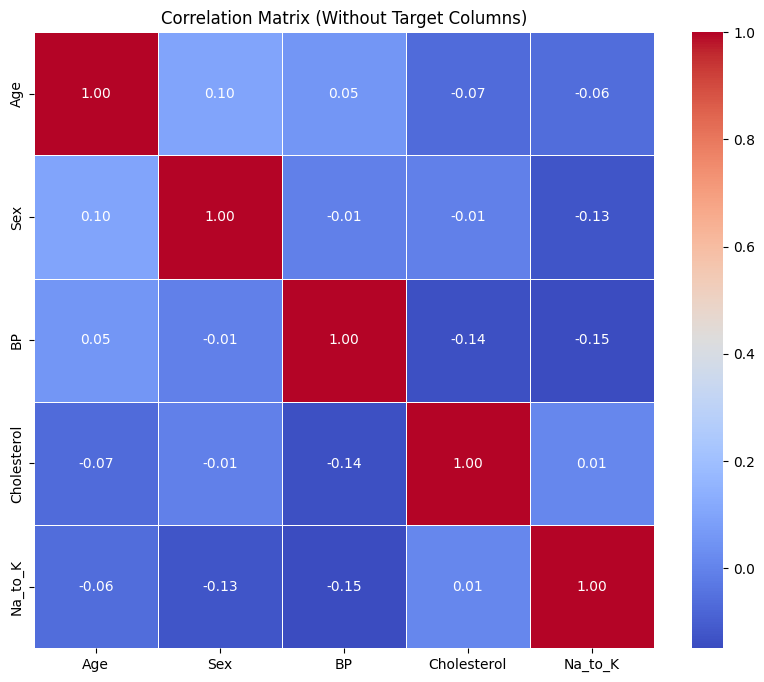

Отфильтрованные признаки (на основе корреляции с 'Age'): ['Sex']


In [ ]:
df_numeric = df.drop(['Drug', 'Drug_binary'], axis=1)

plt.figure(figsize=(10, 8))
sns.heatmap(df_numeric.corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix (Without Target Columns)")
plt.show()

def filter_features_by_correlation(df, target_col, threshold=0.1):
    """
    Возвращает список признаков с корреляцией выше порога с целевой переменной.

    :param df: исходный DataFrame (без категориальных строковых признаков)
    :param target_col: имя целевой переменной
    :param threshold: порог корреляции
    :return: список признаков
    """
    corr = df.corr()
    corr_with_target = corr[target_col].abs().sort_values(ascending=False)
    selected_features = corr_with_target[corr_with_target > threshold].index.tolist()
    selected_features.remove(target_col)
    return selected_features

features_binary = filter_features_by_correlation(df_numeric, 'Age', threshold=0.1)
print("Отфильтрованные признаки (на основе корреляции с 'Age'):", features_binary)

7. Бинарная классификация (до и после нормализации)

In [ ]:
def evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    print(classification_report(y_test, y_pred))
    return acc, prec, rec, f1

knn = KNeighborsClassifier(n_neighbors=5)

acc_raw, prec_raw, rec_raw, f1_raw = evaluate_model(knn, X_train_bin.values, X_test_bin.values, y_train_bin, y_test_bin)

acc_scaled, prec_scaled, rec_scaled, f1_scaled = evaluate_model(knn, X_train_bin_scaled, X_test_bin_scaled, y_train_bin, y_test_bin)

print(f"\nAccuracy до нормализации: {acc_raw:.4f}, после: {acc_scaled:.4f}")

              precision    recall  f1-score   support

           0       0.97      1.00      0.99        34
           1       1.00      0.96      0.98        26

    accuracy                           0.98        60
   macro avg       0.99      0.98      0.98        60
weighted avg       0.98      0.98      0.98        60

              precision    recall  f1-score   support

           0       0.85      1.00      0.92        34
           1       1.00      0.77      0.87        26

    accuracy                           0.90        60
   macro avg       0.93      0.88      0.89        60
weighted avg       0.91      0.90      0.90        60


Accuracy до нормализации: 0.9833, после: 0.9000


8. Перебор гиперпараметра k с кросс-валидацией

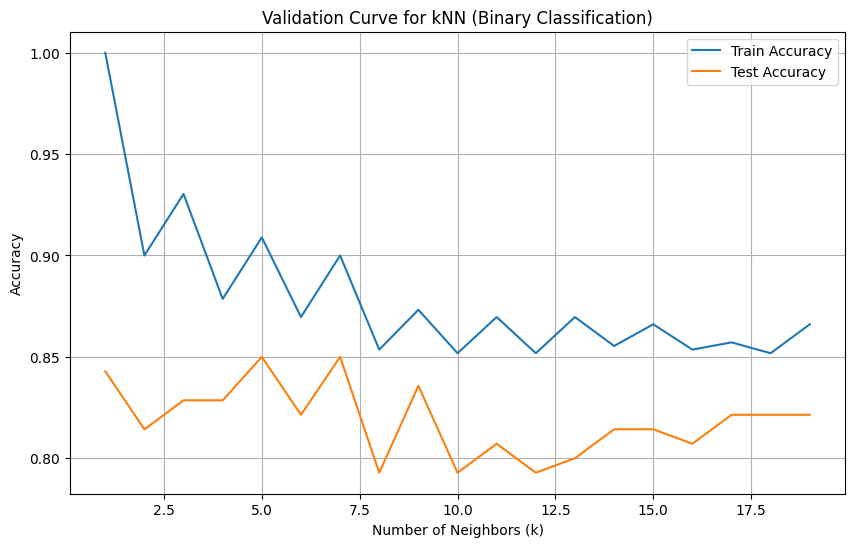

In [ ]:
from sklearn.model_selection import validation_curve

param_range = np.arange(1, 20)
train_scores, test_scores = validation_curve(
    KNeighborsClassifier(),
    X_train_bin_scaled,
    y_train_bin,
    param_name="n_neighbors",
    param_range=param_range,
    scoring="accuracy",
    cv=5
)

train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

plt.figure(figsize=(10,6))
plt.plot(param_range, train_mean, label="Train Accuracy")
plt.plot(param_range, test_mean, label="Test Accuracy")
plt.xlabel("Number of Neighbors (k)")
plt.ylabel("Accuracy")
plt.title("Validation Curve for kNN (Binary Classification)")
plt.legend()
plt.grid(True)
plt.show()

9. Многоклассовая классификация

Accuracy: 0.6833333333333333

Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.67      0.68        27
           1       0.83      0.71      0.77         7
           2       0.50      0.20      0.29         5
           3       0.60      0.60      0.60         5
           4       0.67      0.88      0.76        16

    accuracy                           0.68        60
   macro avg       0.66      0.61      0.62        60
weighted avg       0.68      0.68      0.67        60



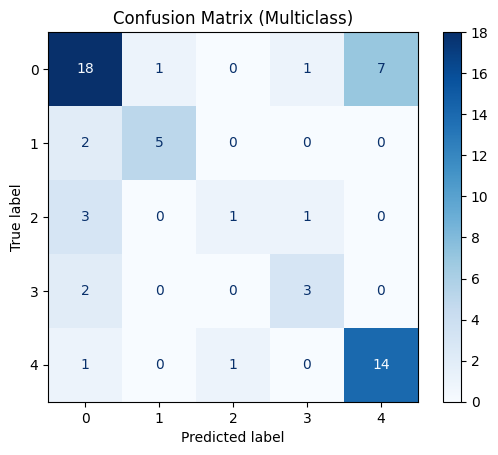

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

df['Drug'] = df['Drug'].astype('category').cat.codes


X = df.drop(['Drug', 'Drug_binary'], axis=1)
y = df['Drug']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

knn_multi = KNeighborsClassifier(n_neighbors=5)
knn_multi.fit(X_train_scaled, y_train)

y_pred = knn_multi.predict(X_test_scaled)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

ConfusionMatrixDisplay.from_estimator(knn_multi, X_test_scaled, y_test, cmap=plt.cm.Blues)
plt.title("Confusion Matrix (Multiclass)")
plt.show()

10. Многоклассовая классификация с фильтрованными признаками

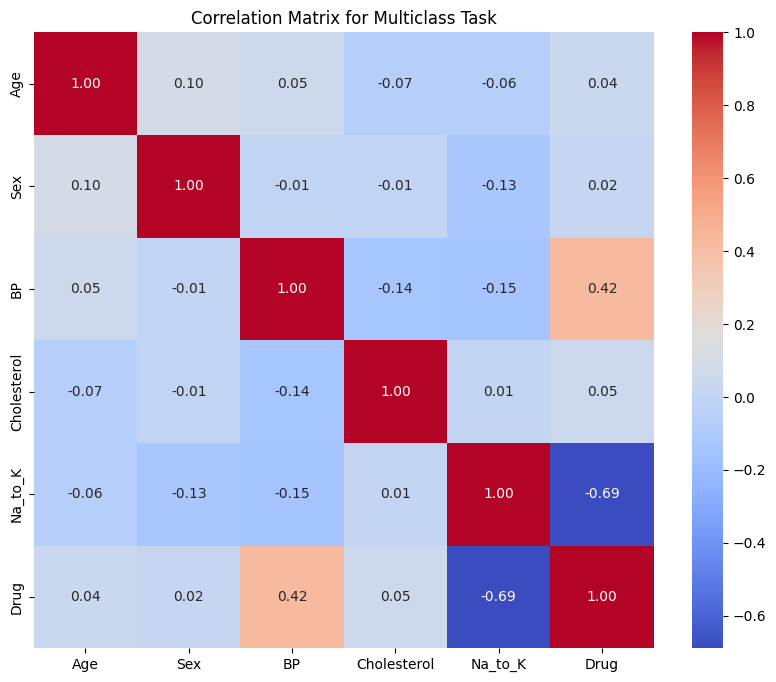

Отфильтрованные признаки (многоклассовая): ['Na_to_K', 'BP']

Accuracy (filtered): 0.7666666666666667

Classification Report (filtered):
               precision    recall  f1-score   support

           0       0.93      1.00      0.96        27
           1       0.50      0.43      0.46         7
           2       0.33      0.40      0.36         5
           3       0.00      0.00      0.00         5
           4       0.78      0.88      0.82        16

    accuracy                           0.77        60
   macro avg       0.51      0.54      0.52        60
weighted avg       0.71      0.77      0.74        60



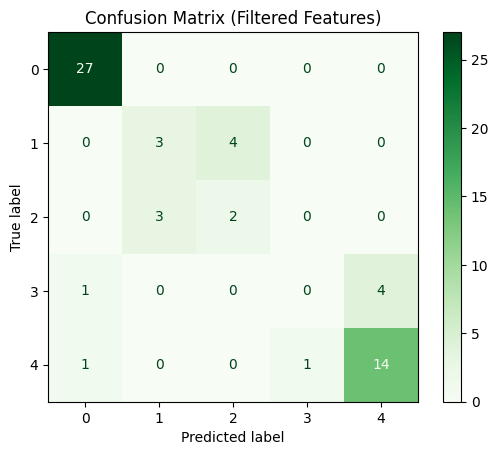

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

df['Drug'] = df['Drug'].astype('category').cat.codes

df_multi = df.drop(['Drug_binary'], axis=1)

plt.figure(figsize=(10, 8))
corr = df_multi.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Matrix for Multiclass Task")
plt.show()

def filter_features_by_correlation(df, target_col, threshold=0.1):
    corr = df.corr()
    corr_with_target = corr[target_col].abs().sort_values(ascending=False)
    selected_features = corr_with_target[corr_with_target > threshold].index.tolist()
    if target_col in selected_features:
        selected_features.remove(target_col)
    return selected_features

features_multi = filter_features_by_correlation(df_multi, 'Drug', threshold=0.1)
print("Отфильтрованные признаки (многоклассовая):", features_multi)

X_filtered = df_multi[features_multi]
y_filtered = df_multi['Drug']

X_train_f, X_test_f, y_train_f, y_test_f = train_test_split(
    X_filtered, y_filtered, test_size=0.3, random_state=42, stratify=y_filtered
)

scaler = StandardScaler()
X_train_f_scaled = scaler.fit_transform(X_train_f)
X_test_f_scaled = scaler.transform(X_test_f)

knn_multi_f = KNeighborsClassifier(n_neighbors=5)
knn_multi_f.fit(X_train_f_scaled, y_train_f)
y_pred_f = knn_multi_f.predict(X_test_f_scaled)

print("\nAccuracy (filtered):", accuracy_score(y_test_f, y_pred_f))
print("\nClassification Report (filtered):\n", classification_report(y_test_f, y_pred_f))

ConfusionMatrixDisplay.from_estimator(knn_multi_f, X_test_f_scaled, y_test_f, cmap=plt.cm.Greens)
plt.title("Confusion Matrix (Filtered Features)")
plt.show()

11. Перебор k с фильтрованными признаками

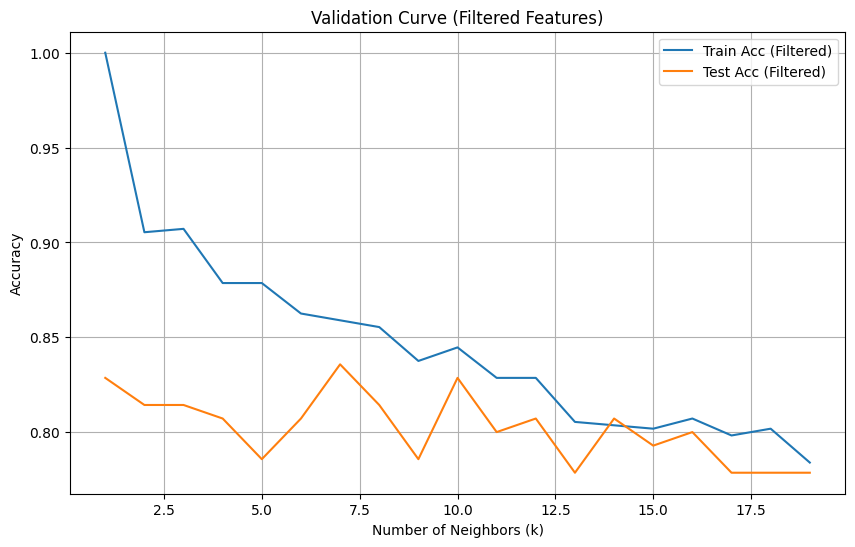

In [ ]:
param_range = np.arange(1, 20)
train_scores_f, test_scores_f = validation_curve(
    KNeighborsClassifier(),
    X_train_f_scaled,
    y_train_f,
    param_name="n_neighbors",
    param_range=param_range,
    scoring="accuracy",
    cv=5
)

train_mean_f = np.mean(train_scores_f, axis=1)
test_mean_f = np.mean(test_scores_f, axis=1)

plt.figure(figsize=(10,6))
plt.plot(param_range, train_mean_f, label="Train Acc (Filtered)")
plt.plot(param_range, test_mean_f, label="Test Acc (Filtered)")
plt.xlabel("Number of Neighbors (k)")
plt.ylabel("Accuracy")
plt.title("Validation Curve (Filtered Features)")
plt.legend()
plt.grid(True)
plt.show()